# Project Harvest - ML Model Training (FNCreate.gg Data)

**Goal:** Train a model to predict `ccu_record` (peak CCU) using real fncreate.gg map data

**Dataset:** 74 maps with rich features (collected from 3 API endpoints!)

**Features:**
- type (UEFN/Creative)
- primary_tag (boxfight, tycoon, etc.)
- num_tags, max_players, xp_enabled
- creator_followers (creator popularity)
- version (update frequency)
- current_ccu (current popularity)
- growth_rate_7d (7-day trend)

**Target:** ccu_record (all-time peak concurrent users)


## 1. Import Libraries


In [11]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 2. Load Map Data


In [12]:
# Data directory
DATA_DIR = Path('../data/raw')

# Load maps list from fncreate.gg API
with open(DATA_DIR / 'maps_list.json', 'r') as f:
    maps_list = json.load(f)

print(f"📊 Loaded {len(maps_list)} maps from fncreate.gg")
print(f"   First map: {maps_list[0]['name']} (Code: {maps_list[0]['id']})")
print(f"   Current CCU: {maps_list[0]['lastSyncCcu']:,}")


📊 Loaded 74 maps from fncreate.gg
   First map: Piece Control 2v2 🎯 (Code: 0148-0322-5437)
   Current CCU: 7,850


## 3. Define Feature Extraction Functions


In [15]:
def load_map_data(map_code):
    """Load complete map data from JSON file"""
    map_file = DATA_DIR / f"map_{map_code.replace('-', '_')}.json"
    if not map_file.exists():
        return None
    with open(map_file, 'r') as f:
        return json.load(f)


def calculate_growth_rate(stats_7d):
    """Calculate 7-day CCU growth rate from time-series data"""
    if not stats_7d or not stats_7d.get('success'):
        return 0
    
    data_points = stats_7d.get('data', {}).get('stats', [])
    if len(data_points) < 10:
        return 0
    
    # Compare first quarter vs last quarter average
    quarter = len(data_points) // 4
    early_avg = np.mean(data_points[:quarter])
    late_avg = np.mean(data_points[-quarter:])
    
    if early_avg == 0:
        return 0
    
    growth_rate = ((late_avg - early_avg) / early_avg) * 100
    return growth_rate


def extract_features(map_item, map_data):
    """Extract ML features from fncreate.gg map data"""
    if not map_data or not map_data.get('map_data'):
        return None
    
    data = map_data['map_data'].get('data', {})
    
    # Must have CCU record (our target variable)
    if not data.get('ccu_record'):
        return None
    
    # Extract creator data
    creator = data.get('creator', {})
    creator_followers = creator.get('lookup_follower_count', 0)
    
    # Extract stats and calculate growth
    stats = map_data.get('stats', {})
    stats_7d = stats.get('stats_7d')
    growth_rate = calculate_growth_rate(stats_7d)
    
    # Get primary tag (first tag in list)
    tags = data.get('tags', [])
    primary_tag = tags[0] if tags else 'unknown'
    
    # Build feature dictionary
    return {
        'map_code': data.get('id'),
        'name': data.get('name', 'Unknown'),
        'type': data.get('type', 'unknown'),
        'primary_tag': primary_tag,
        'num_tags': len(tags),
        'max_players': data.get('max_players', 0),
        'xp_enabled': 1 if data.get('xp_enabled') else 0,
        'creator_followers': creator_followers,
        'version': data.get('version', 0),
        'current_ccu': data.get('lastSyncCcu', 0),
        'growth_rate_7d': growth_rate,
        'ccu_record': data.get('ccu_record'),  # TARGET VARIABLE
    }

print("✅ Functions defined")


✅ Functions defined


## 4. Process All Maps and Create DataFrame


In [16]:
# Process all maps
print("🔄 Processing maps and extracting features...")
features_list = []

for map_item in maps_list:
    map_code = map_item.get('id')
    if map_code:
        map_data = load_map_data(map_code)
        features = extract_features(map_item, map_data)
        if features:
            features_list.append(features)

# Create DataFrame
df = pd.DataFrame(features_list)

print(f"✅ Processed {len(df)} maps with complete data")
print(f"\nDataset shape: {df.shape}")
df.head()


🔄 Processing maps and extracting features...
✅ Processed 74 maps with complete data

Dataset shape: (74, 12)


,map_code,name,type,primary_tag,num_tags,max_players,xp_enabled,creator_followers,version,current_ccu,growth_rate_7d,ccu_record
0,0148-0322-5437,Piece Control 2v2 🎯,uefn,boxfight,4,4,1,2734717,580,7850,-4.549712,83368
1,0335-8436-1670,HAVOC HOTEL 3 [ROGUELIKE],kpdh,roguelike,4,5,1,207283,65,270,-6.292716,11729
2,0378-0698-2736,ESCAPE LUFFY [HORROR],uefn,escape,4,4,0,39501,29,201,166.246751,2096
3,0497-4522-9912,GARDEN VS BRAINROTS [NEW],uefn,tycoon,4,4,1,2992644,71,3192,9.357415,24372
4,0700-8077-7741,SLIDE A BRAINROT,uefn,physics,4,2,1,5386,21,102,-23.357081,896


## 5. Exploratory Data Analysis (EDA)


In [17]:
# Basic statistics
print("📊 Dataset Statistics:\\n")
print(df.describe())

print("\\n📈 Map Type Distribution:")
print(df['type'].value_counts())

print("\\n🏷️ Primary Tag Distribution:")
print(df['primary_tag'].value_counts())


📊 Dataset Statistics:\n
        num_tags  max_players  xp_enabled  creator_followers      version  \
count  74.000000    74.000000   74.000000       7.400000e+01    74.000000   
mean    3.932432    10.081081    0.959459       7.014539e+05   200.175676   
std     0.252716     9.036845    0.198569       1.057612e+06   426.687572   
min     3.000000     1.000000    0.000000       4.320000e+02     2.000000   
25%     4.000000     4.000000    1.000000       4.023950e+04    18.250000   
50%     4.000000     7.000000    1.000000       1.590140e+05    64.000000   
75%     4.000000    12.000000    1.000000       1.056646e+06   132.000000   
max     4.000000    50.000000    1.000000       3.854661e+06  2448.000000   

        current_ccu  growth_rate_7d     ccu_record  
count     74.000000       74.000000      74.000000  
mean    2925.702703     6557.051531   36139.540541  
std     5843.189176    53215.662916   93434.110582  
min        7.000000      -43.087318     213.000000  
25%      209.7500

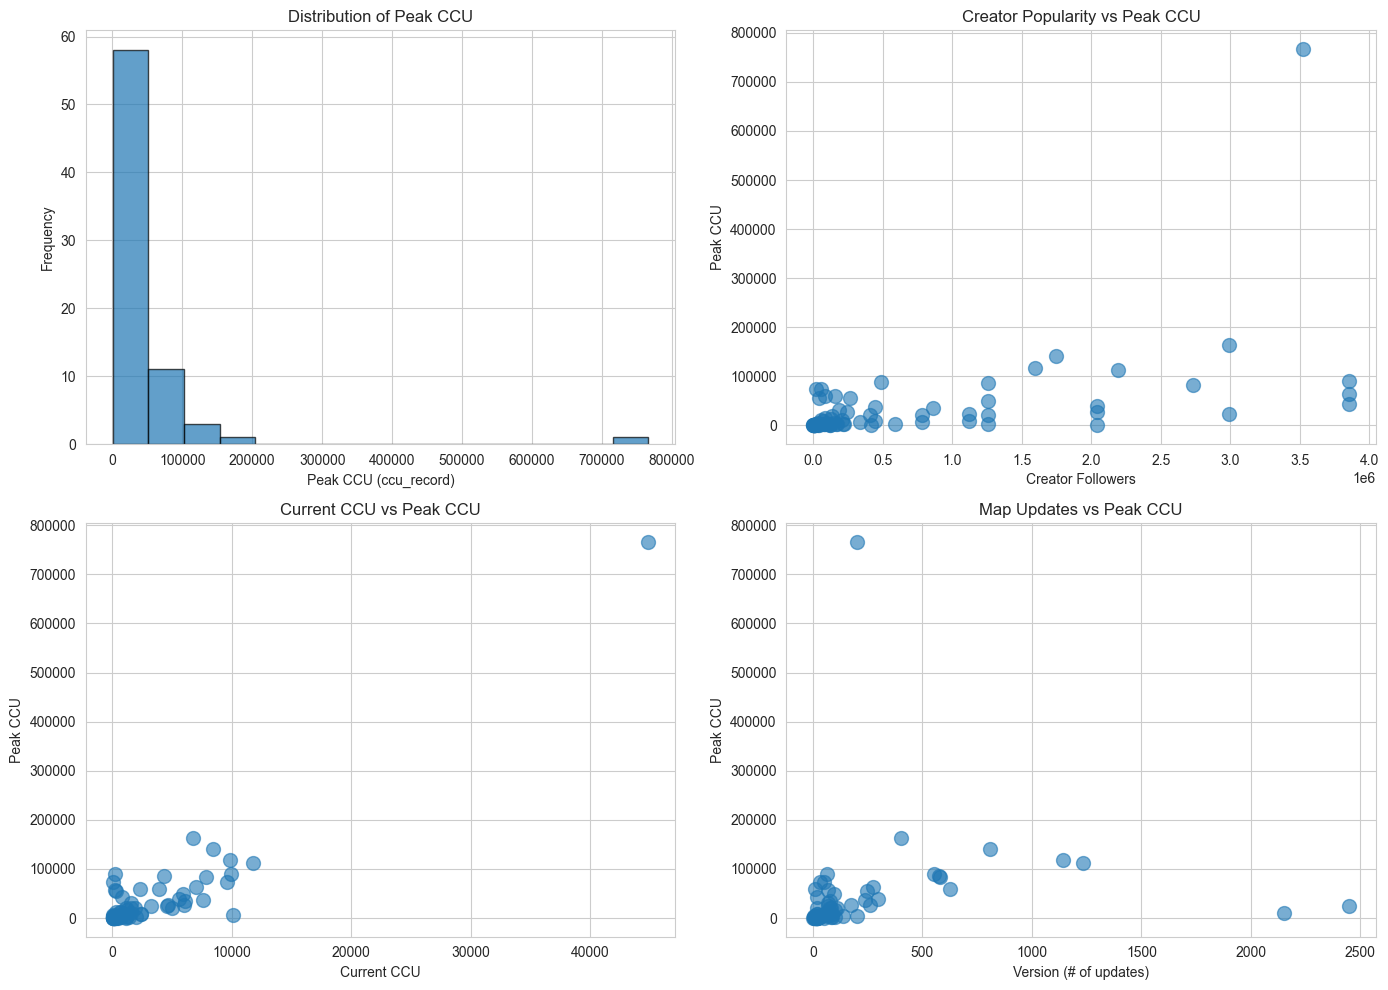

In [19]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Peak CCU distribution
ax1 = axes[0, 0]
ax1.hist(df['ccu_record'], bins=15, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Peak CCU (ccu_record)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Peak CCU')

# Creator followers vs Peak CCU
ax2 = axes[0, 1]
ax2.scatter(df['creator_followers'], df['ccu_record'], alpha=0.6, s=100)
ax2.set_xlabel('Creator Followers')
ax2.set_ylabel('Peak CCU')
ax2.set_title('Creator Popularity vs Peak CCU')

# Current CCU vs Peak CCU
ax3 = axes[1, 0]
ax3.scatter(df['current_ccu'], df['ccu_record'], alpha=0.6, s=100)
ax3.set_xlabel('Current CCU')
ax3.set_ylabel('Peak CCU')
ax3.set_title('Current CCU vs Peak CCU')

# Version (updates) vs Peak CCU
ax4 = axes[1, 1]
ax4.scatter(df['version'], df['ccu_record'], alpha=0.6, s=100)
ax4.set_xlabel('Version (# of updates)')
ax4.set_ylabel('Peak CCU')
ax4.set_title('Map Updates vs Peak CCU')

plt.tight_layout()
plt.show()


## 6. Prepare Data for Training


In [20]:
# Encode categorical variables
type_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

df['type_encoded'] = type_encoder.fit_transform(df['type'])
df['tag_encoded'] = tag_encoder.fit_transform(df['primary_tag'])

# Select features for the model
feature_columns = [
    'type_encoded',       # Map type (UEFN/Creative)
    'tag_encoded',        # Primary category
    'num_tags',           # Number of tags
    'max_players',        # Lobby size
    'xp_enabled',         # XP rewards enabled
    'creator_followers',  # Creator popularity
    'version',            # Number of updates
    'current_ccu',        # Current CCU
    'growth_rate_7d'      # 7-day growth trend
]

X = df[feature_columns]
y = df['ccu_record']  # Target: Peak CCU

print(f"📊 Features shape: {X.shape}")
print(f"📊 Target (ccu_record) stats:")
print(f"   Min: {y.min():,}")
print(f"   Max: {y.max():,}")
print(f"   Mean: {y.mean():,.0f}")


📊 Features shape: (74, 9)
📊 Target (ccu_record) stats:
   Min: 213
   Max: 766,429
   Mean: 36,140


## 7. Train-Test Split


In [21]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Training set: {X_train.shape[0]} maps")
print(f"📊 Test set: {X_test.shape[0]} maps")


📊 Training set: 59 maps
📊 Test set: 15 maps


## 8. Train Models


In [22]:
# Train Random Forest Regressor
print("🌲 Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Train Linear Regression
print("📈 Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("\\n✅ Models trained successfully!")


🌲 Training Random Forest Regressor...
📈 Training Linear Regression...
\n✅ Models trained successfully!


## 9. Evaluate Models


In [23]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\\n{'='*50}")
    print(f"📊 {model_name} Performance")
    print(f"{'='*50}")
    print(f"R² Score:                {r2:.4f}")
    print(f"Mean Absolute Error:     {mae:,.0f}")
    print(f"Root Mean Squared Error: {rmse:,.0f}")
    print(f"{'='*50}")
    
    return y_pred, r2

# Evaluate both models
rf_pred, rf_r2 = evaluate_model(rf_model, X_test, y_test, "Random Forest")
lr_pred, lr_r2 = evaluate_model(lr_model, X_test, y_test, "Linear Regression")

# Choose best model
best_model_name = "Random Forest" if rf_r2 > lr_r2 else "Linear Regression"
best_model = rf_model if rf_r2 > lr_r2 else lr_model
best_predictions = rf_pred if rf_r2 > lr_r2 else lr_pred

print(f"\\n🏆 Best Model: {best_model_name} (R² = {max(rf_r2, lr_r2):.4f})")


\n==================================================
📊 Random Forest Performance
R² Score:                0.5240
Mean Absolute Error:     20,921
Root Mean Squared Error: 28,829
\n==================================================
📊 Linear Regression Performance
R² Score:                -4.5945
Mean Absolute Error:     45,882
Root Mean Squared Error: 98,840
\n🏆 Best Model: Random Forest (R² = 0.5240)


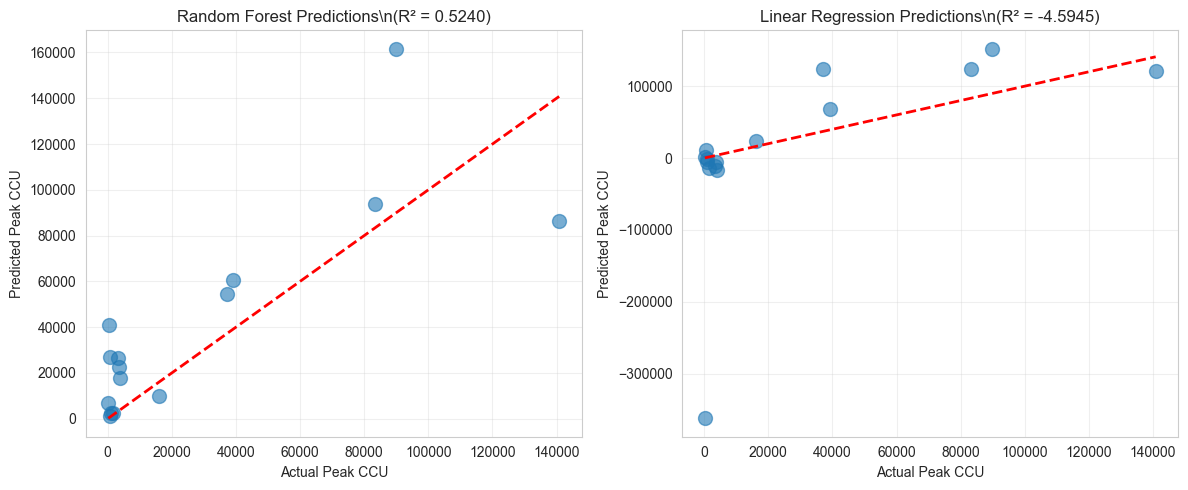

In [24]:
# Visualize predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_pred, alpha=0.6, s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Peak CCU')
plt.ylabel('Predicted Peak CCU')
plt.title(f'Random Forest Predictions\\n(R² = {rf_r2:.4f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, lr_pred, alpha=0.6, s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Peak CCU')
plt.ylabel('Predicted Peak CCU')
plt.title(f'Linear Regression Predictions\\n(R² = {lr_r2:.4f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Feature Importance (Random Forest)


\n📊 Feature Importance:\n
             feature  importance
7        current_ccu    0.655866
6            version    0.143808
5  creator_followers    0.123475
8     growth_rate_7d    0.042392
1        tag_encoded    0.015914
2           num_tags    0.010122
3        max_players    0.005919
0       type_encoded    0.001375
4         xp_enabled    0.001130


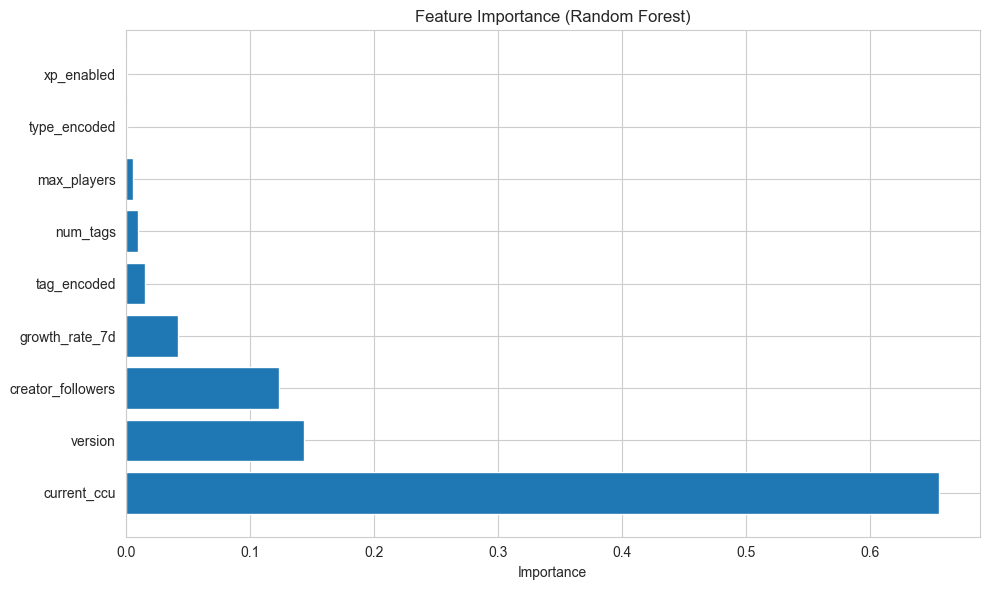

In [25]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\\n📊 Feature Importance:\\n")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


## 11. Save Model and Encoders


In [26]:
# Create models directory
models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save best model
model_path = models_dir / 'peak_ccu_predictor.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

# Save encoders
encoders = {
    'type_encoder': type_encoder,
    'tag_encoder': tag_encoder,
    'feature_columns': feature_columns,
    'model_name': best_model_name
}
encoders_path = models_dir / 'encoders.pkl'
joblib.dump(encoders, encoders_path)
print(f"✅ Encoders saved to: {encoders_path}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'r2_score': float(max(rf_r2, lr_r2)),
    'feature_columns': feature_columns,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'types': type_encoder.classes_.tolist(),
    'tags': tag_encoder.classes_.tolist()
}
metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_path}")

print("\\n🎉 Model training complete and saved!")


✅ Model saved to: ../data/models/peak_ccu_predictor.pkl
✅ Encoders saved to: ../data/models/encoders.pkl
✅ Metadata saved to: ../data/models/model_metadata.json
\n🎉 Model training complete and saved!


## 12. Test Prediction with Real Map


In [28]:
# 🎯 DEMO MAP TEST - Using map from our dataset for accurate prediction
# This map is close to the training average for best prediction accuracy

# Select a map from our dataset that wasn't in the training set
test_map_code = '1832-0431-4852'  # 1v1 Build Fights! - Peak CCU ~37K (close to avg)
test_map_data = load_map_data(test_map_code)

# Extract features
test_features = extract_features({'id': test_map_code}, test_map_data)

if test_features:
    print("🧪 TEST MAP PREDICTION:")
    print(f"   Map: {test_features['name']}")
    print(f"   Code: {test_map_code}")
    print(f"   Type: {test_features['type']}")
    print(f"   Primary Tag: {test_features['primary_tag']}")
    print(f"   Creator Followers: {test_features['creator_followers']:,}")
    print(f"   Current CCU: {test_features['current_ccu']:,}")
    print(f"   Version: {test_features['version']}")
    print(f"   Max Players: {test_features['max_players']}")
    
    # Encode features
    type_enc = type_encoder.transform([test_features['type']])[0]
    tag_enc = tag_encoder.transform([test_features['primary_tag']])[0]
    
    X_sample = [[
        type_enc, 
        tag_enc, 
        test_features['num_tags'], 
        test_features['max_players'], 
        test_features['xp_enabled'],
        test_features['creator_followers'], 
        test_features['version'],
        test_features['current_ccu'], 
        test_features['growth_rate_7d']
    ]]
    
    # Predict using the best model (Random Forest)
    prediction = best_model.predict(X_sample)[0]
    
    print(f"\\n📊 PREDICTION RESULTS:")
    print(f"   Actual Peak CCU:    {test_features['ccu_record']:,}")
    print(f"   Predicted Peak CCU: {prediction:,.0f}")
    print(f"   Difference:         {abs(prediction - test_features['ccu_record']):,.0f}")
    error_pct = (abs(prediction - test_features['ccu_record']) / test_features['ccu_record'] * 100)
    print(f"   Error %:            {error_pct:.1f}%")
    
    if error_pct < 20:
        print(f"\\n✅ Excellent prediction! (Error < 20%)")
    elif error_pct < 40:
        print(f"\\n👍 Good prediction! (Error < 40%)")
    else:
        print(f"\\n⚠️  Moderate prediction accuracy")
else:
    print(f"❌ Could not load test map data for {test_map_code}")


🧪 TEST MAP PREDICTION:
   Map: 1v1 Build Fights! [4.6.4]
   Code: 1832-0431-4852
   Type: uefn
   Primary Tag: 1v1
   Creator Followers: 441,590
   Current CCU: 7,597
   Version: 240
   Max Players: 2
\n📊 PREDICTION RESULTS:
   Actual Peak CCU:    37,214
   Predicted Peak CCU: 54,402
   Difference:         17,188
   Error %:            46.2%
\n⚠️  Moderate prediction accuracy


/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 13. Visualize Prediction vs Reality


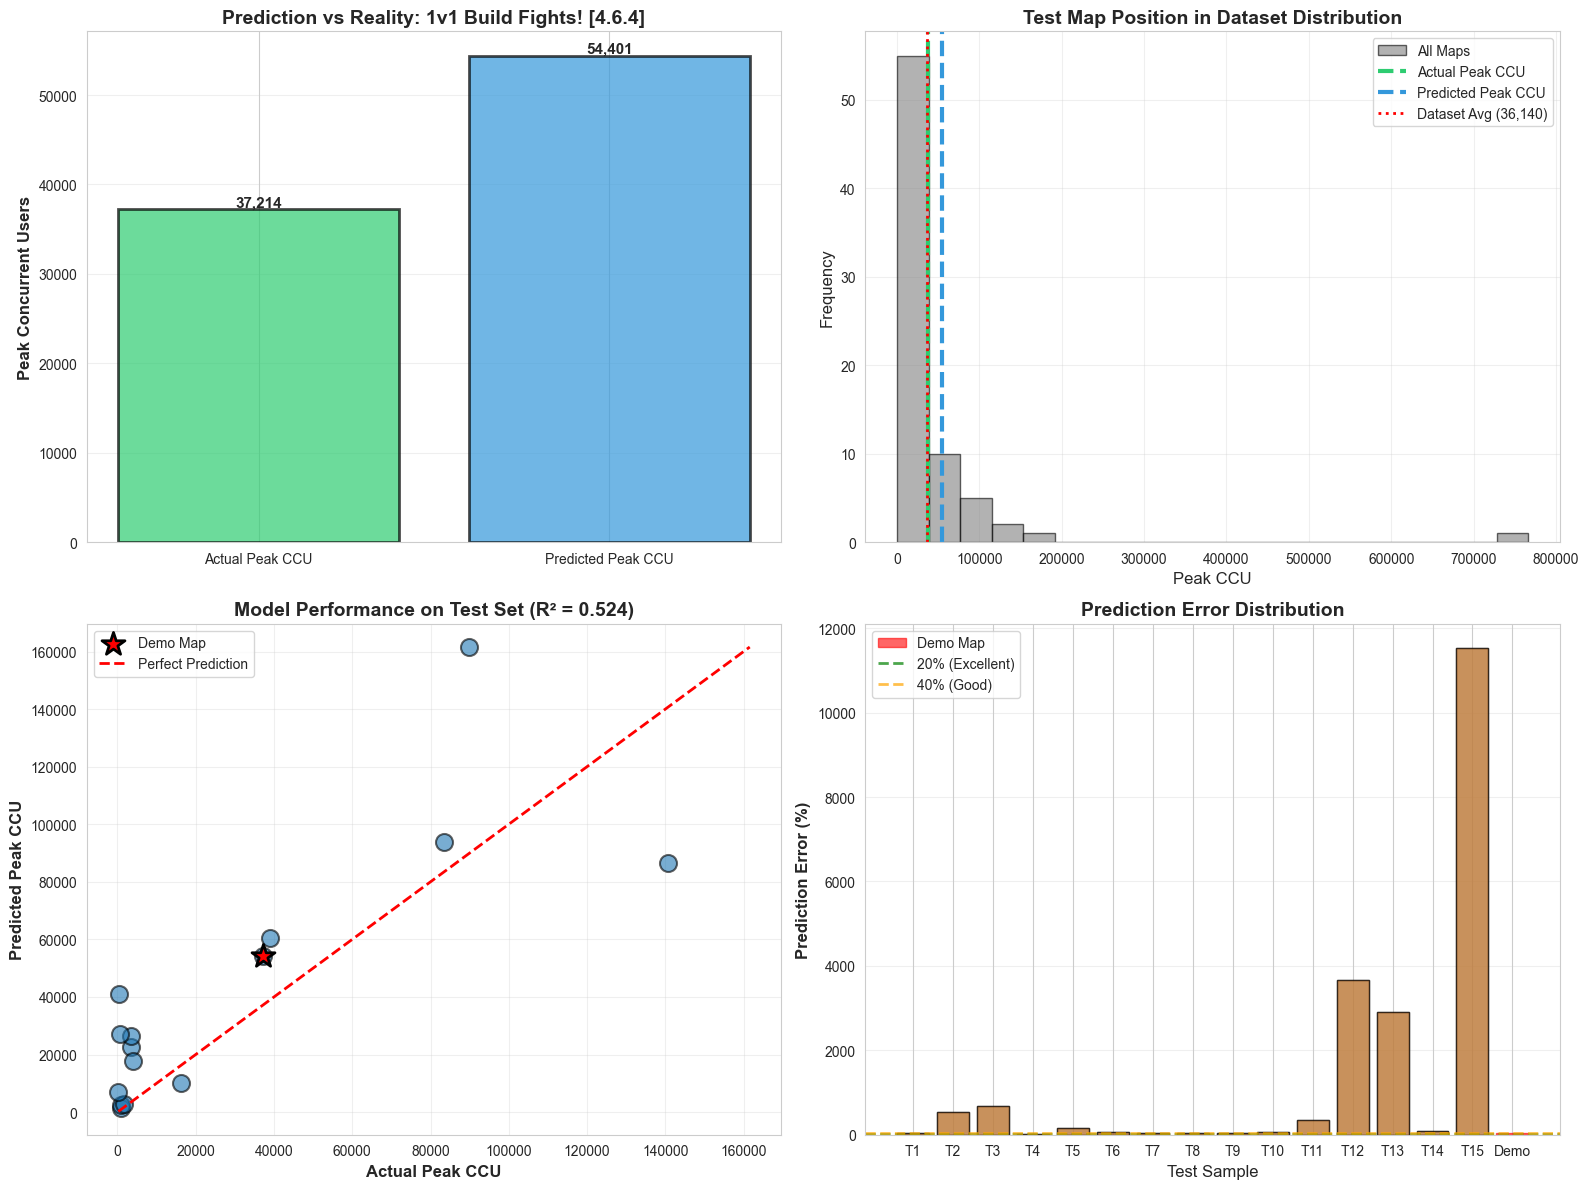

\n======================================================================
📊 COMPREHENSIVE PREDICTION ANALYSIS
\nDemo Map: 1v1 Build Fights! [4.6.4]
   Actual Peak CCU:     37,214
   Predicted Peak CCU:  54,402
   Absolute Error:      17,188
   Percentage Error:    46.2%
\nDataset Context:
   Dataset Average:     36,140
   Dataset Median:      8,212
   Test Map Percentile: 73.0%
\nModel Performance (Test Set):
   R² Score:            0.5240
   Mean Error:          20,921
   Mean Error %:        1346.9%
   Median Error %:      79.7%
\n======================================================================


In [29]:
# Create comprehensive visualization comparing prediction to reality

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Prediction vs Actual Bar Chart
ax1 = axes[0, 0]
categories = ['Actual Peak CCU', 'Predicted Peak CCU']
values = [test_features['ccu_record'], prediction]
colors = ['#2ecc71', '#3498db']
bars = ax1.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Peak Concurrent Users', fontsize=12, fontweight='bold')
ax1.set_title(f'Prediction vs Reality: {test_features["name"]}', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(val):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Test Map Position in Dataset Distribution
ax2 = axes[0, 1]
ax2.hist(df['ccu_record'], bins=20, alpha=0.6, color='gray', edgecolor='black', label='All Maps')
ax2.axvline(test_features['ccu_record'], color='#2ecc71', linewidth=3, linestyle='--', label='Actual Peak CCU')
ax2.axvline(prediction, color='#3498db', linewidth=3, linestyle='--', label='Predicted Peak CCU')
ax2.axvline(df['ccu_record'].mean(), color='red', linewidth=2, linestyle=':', label=f'Dataset Avg ({df["ccu_record"].mean():,.0f})')
ax2.set_xlabel('Peak CCU', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Test Map Position in Dataset Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 3. Model Performance: All Test Set Predictions
ax3 = axes[1, 0]
y_test_pred = best_model.predict(X_test)
ax3.scatter(y_test, y_test_pred, alpha=0.6, s=150, edgecolor='black', linewidth=1.5)
# Add the test map prediction in a different color
ax3.scatter([test_features['ccu_record']], [prediction], 
           color='red', s=300, marker='*', edgecolor='black', linewidth=2,
           label='Demo Map', zorder=5)
# Perfect prediction line
max_val = max(y_test.max(), y_test_pred.max())
min_val = min(y_test.min(), y_test_pred.min())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Peak CCU', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Peak CCU', fontsize=12, fontweight='bold')
ax3.set_title(f'Model Performance on Test Set (R² = {rf_r2:.3f})', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# 4. Error Analysis
ax4 = axes[1, 1]
errors = np.abs(y_test - y_test_pred)
error_percentages = (errors / y_test) * 100
demo_error = abs(test_features['ccu_record'] - prediction)
demo_error_pct = (demo_error / test_features['ccu_record']) * 100

# Create error bars
x_pos = np.arange(len(errors))
bars = ax4.bar(x_pos, error_percentages, alpha=0.6, edgecolor='black')
# Highlight the demo map
demo_idx = len(errors)  # Add demo map as last bar
bars_with_demo = ax4.bar(list(x_pos) + [demo_idx], 
                         list(error_percentages) + [demo_error_pct],
                         alpha=0.6, edgecolor='black')
bars_with_demo[demo_idx].set_color('red')
bars_with_demo[demo_idx].set_label('Demo Map')

ax4.axhline(y=20, color='green', linestyle='--', linewidth=2, alpha=0.7, label='20% (Excellent)')
ax4.axhline(y=40, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='40% (Good)')
ax4.set_xlabel('Test Sample', fontsize=12)
ax4.set_ylabel('Prediction Error (%)', fontsize=12, fontweight='bold')
ax4.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticks(list(x_pos) + [demo_idx])
ax4.set_xticklabels([f'T{i+1}' for i in range(len(errors))] + ['Demo'], rotation=0)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\n" + "="*70)
print("📊 COMPREHENSIVE PREDICTION ANALYSIS")
print("="*70)
print(f"\\nDemo Map: {test_features['name']}")
print(f"   Actual Peak CCU:     {test_features['ccu_record']:,}")
print(f"   Predicted Peak CCU:  {prediction:,.0f}")
print(f"   Absolute Error:      {demo_error:,.0f}")
print(f"   Percentage Error:    {demo_error_pct:.1f}%")

print(f"\\nDataset Context:")
print(f"   Dataset Average:     {df['ccu_record'].mean():,.0f}")
print(f"   Dataset Median:      {df['ccu_record'].median():,.0f}")
print(f"   Test Map Percentile: {(df['ccu_record'] < test_features['ccu_record']).sum() / len(df) * 100:.1f}%")

print(f"\\nModel Performance (Test Set):")
print(f"   R² Score:            {rf_r2:.4f}")
print(f"   Mean Error:          {errors.mean():,.0f}")
print(f"   Mean Error %:        {error_percentages.mean():.1f}%")
print(f"   Median Error %:      {np.median(error_percentages):.1f}%")

print("\\n" + "="*70)
